<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Network Robustness and Communities

---

<h1>Lesson Guide<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Learning-Objectives" data-toc-modified-id="Learning-Objectives-0.1">Learning Objectives</a></span></li></ul></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Connected-Components" data-toc-modified-id="Connected-Components-2">Connected Components</a></span></li><li><span><a href="#Centrality-Measures" data-toc-modified-id="Centrality-Measures-3">Centrality Measures</a></span><ul class="toc-item"><li><span><a href="#Betweenness-Centrality" data-toc-modified-id="Betweenness-Centrality-3.1">Betweenness Centrality</a></span></li></ul></li><li><span><a href="#Robustness" data-toc-modified-id="Robustness-4">Robustness</a></span><ul class="toc-item"><li><span><a href="#Breaking-the-giant-component" data-toc-modified-id="Breaking-the-giant-component-4.1">Breaking the giant component</a></span></li><li><span><a href="#Breaking-the-graph-randomly" data-toc-modified-id="Breaking-the-graph-randomly-4.2">Breaking the graph randomly</a></span></li><li><span><a href="#Averaging-the-random-result" data-toc-modified-id="Averaging-the-random-result-4.3">Averaging the random result</a></span></li><li><span><a href="#Breaking-with-Betweenness-Centrality" data-toc-modified-id="Breaking-with-Betweenness-Centrality-4.4">Breaking with Betweenness Centrality</a></span></li></ul></li><li><span><a href="#Community-detection" data-toc-modified-id="Community-detection-5">Community detection</a></span></li><li><span><a href="#The-Girvan-Newman-algorithm" data-toc-modified-id="The-Girvan-Newman-algorithm-6">The Girvan-Newman algorithm</a></span></li><li><span><a href="#Hierarchical-clustering" data-toc-modified-id="Hierarchical-clustering-7">Hierarchical clustering</a></span><ul class="toc-item"><li><span><a href="#Exercise" data-toc-modified-id="Exercise-7.1">Exercise</a></span><ul class="toc-item"><li><span><a href="#Solution-Karate-Club-Graph-(double-click)" data-toc-modified-id="Solution-Karate-Club-Graph-(double-click)-7.1.1">Solution Karate Club Graph (double click)</a></span></li><li><span><a href="#Solution-Davis-Graph-(double-click)" data-toc-modified-id="Solution-Davis-Graph-(double-click)-7.1.2">Solution Davis Graph (double click)</a></span></li><li><span><a href="#Solution-Les-Miserables-Graph-(double-click)" data-toc-modified-id="Solution-Les-Miserables-Graph-(double-click)-7.1.3">Solution Les Miserables Graph (double click)</a></span></li></ul></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-8">Conclusions</a></span></li><li><span><a href="#Additional-Resources" data-toc-modified-id="Additional-Resources-9">Additional Resources</a></span></li><li><span><a href="#Network-data-resources" data-toc-modified-id="Network-data-resources-10">Network data resources</a></span></li></ul></div>

<a id="learning-objectives"></a>
### Learning Objectives

- Understand the concept of network centrality measures
- Asses the robustness of a network under random and targeted attacks
- Identify network communities

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx

plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introduction

In network analysis, we often want to know which nodes or edges are the most important ones, what happens if some of the nodes or edges are removed, or are there nodes which form communities or clusters.

## Connected Components

A graph can consist of several subgraphs which are not linked to each other. These subgraphs are called the connected components.

To illustrate this situation, we generate a test graph with two components (i.e. disconnected parts).

Note that in this example we show how to define a graph by reading in an edge list.

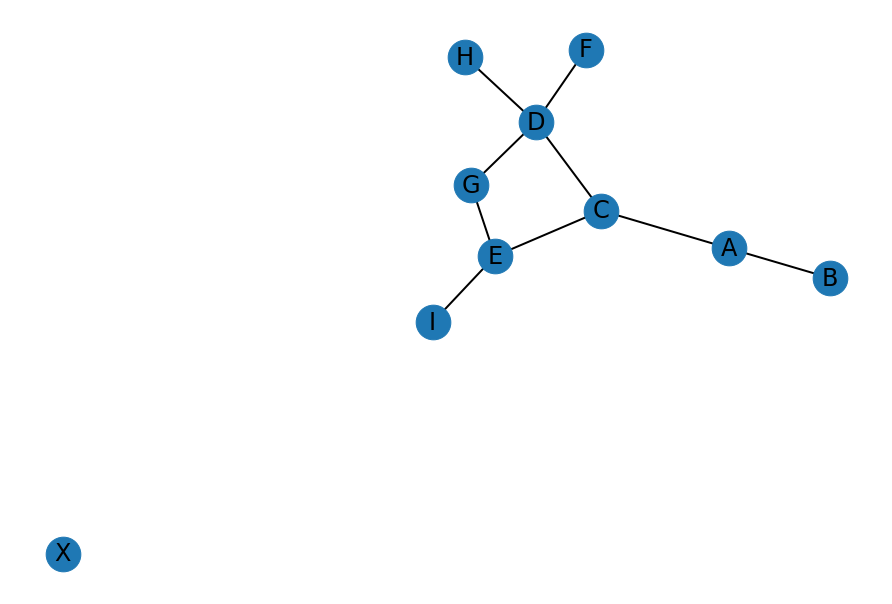

In [3]:
# Generating the test graph with two components
# First component
G_test = nx.Graph()
G_test.add_edges_from([('A', 'B'), ('A', 'C'), ('C', 'D'), ('C', 'E'),
                       ('D', 'F'), ('D', 'H'), ('D', 'G'), ('E', 'G'),
                       ('E', 'I')])
# Second component
G_test.add_node('X')
nx.draw(G_test, with_labels=True)

We can extract the various connected components from a graph. Here we are interested in the largest of these connected components. We will call it the *giant component* (we will not define that more precisely here).

In [4]:
def giant_component_size(G):
    '''Take a grah G and Return the largest connected component, 
        a list of the connected components and 
        the number of connected components'''
    components = [(len(G), list(G)) for G in nx.connected_components(G)]
    num_components = len(components)
    GCC = [y[1] for y in components if y[0]
           == max([x[0] for x in components])][0]
    return GCC, components, num_components

In [5]:
GCC, components, n = giant_component_size(G_test)

In [6]:
print("Components:\n", components)
print("Number of components:\n", n)
print("Giant Connected Component:\n", GCC)

Components:
 [(9, ['F', 'B', 'E', 'H', 'G', 'D', 'I', 'A', 'C']), (1, ['X'])]
Number of components:
 2
Giant Connected Component:
 ['F', 'B', 'E', 'H', 'G', 'D', 'I', 'A', 'C']


In [7]:
[nx.info(G_test.subgraph(G)).split('\n')
 +list(G_test.subgraph(G).nodes())
 for G in nx.connected_components(G_test)]

[['Name: ',
  'Type: Graph',
  'Number of nodes: 9',
  'Number of edges: 9',
  'Average degree:   2.0000',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'H',
  'G',
  'I'],
 ['Name: ',
  'Type: Graph',
  'Number of nodes: 1',
  'Number of edges: 0',
  'Average degree:   0.0000',
  'X']]

## Centrality Measures

### Betweenness Centrality

Often we have to identify nodes or links which have more importance for the network. Rankings of nodes or edges can be obtained with various **centrality measures**. One of them is the so-called betweenness centrality. 

In a network, one can determine the shortest path between any two nodes and count how many of these paths run through each node or link. This number gives the vertex or edge betweenness. 

Think for example of connections between any two points in London. If they are on the same side of the Thames, the shortest paths between a pair of any two points will not have many segments in common. If the points are on different sides of the Thames, one has to use one of the bridges and these will have a high betweenness.

In [8]:
G_GCC = G_test.subgraph(GCC).copy()

node_centrality = nx.betweenness_centrality(G_GCC)
edge_centrality = nx.edge_betweenness_centrality(G_GCC)

In [9]:
node_centrality

{'A': 0.25,
 'B': 0.0,
 'C': 0.5357142857142857,
 'D': 0.5178571428571428,
 'E': 0.30357142857142855,
 'F': 0.0,
 'H': 0.0,
 'G': 0.10714285714285714,
 'I': 0.0}

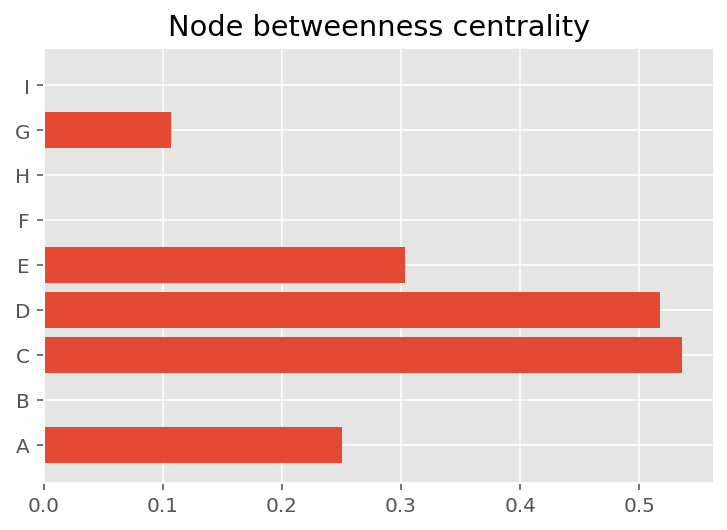

In [10]:
plt.barh(list(range(len(list(node_centrality.values())))),
         list(node_centrality.values()))
plt.yticks(list(range(len(node_centrality))), list(node_centrality.keys()))
plt.title('Node betweenness centrality')
plt.show()

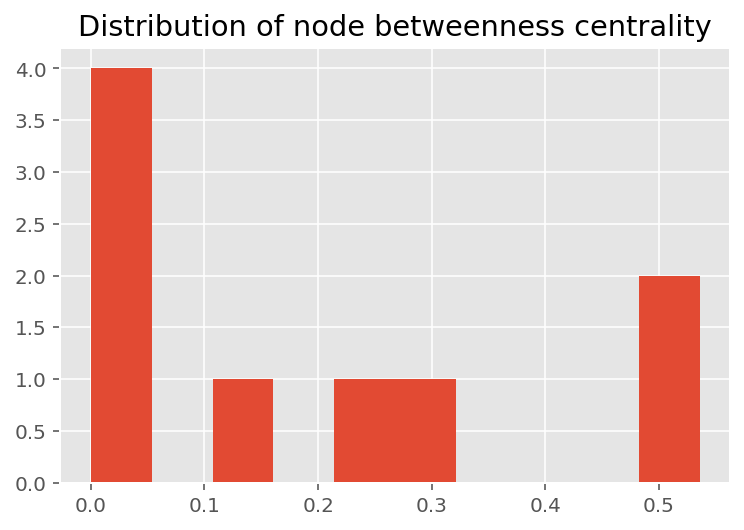

In [11]:
plt.hist(list(node_centrality.values()))
plt.title('Distribution of node betweenness centrality')
plt.show()

In [12]:
edge_centrality

{('A', 'B'): 0.2222222222222222,
 ('A', 'C'): 0.38888888888888884,
 ('C', 'D'): 0.375,
 ('C', 'E'): 0.29166666666666663,
 ('D', 'F'): 0.2222222222222222,
 ('D', 'H'): 0.2222222222222222,
 ('D', 'G'): 0.20833333333333331,
 ('E', 'G'): 0.18055555555555555,
 ('E', 'I'): 0.2222222222222222}

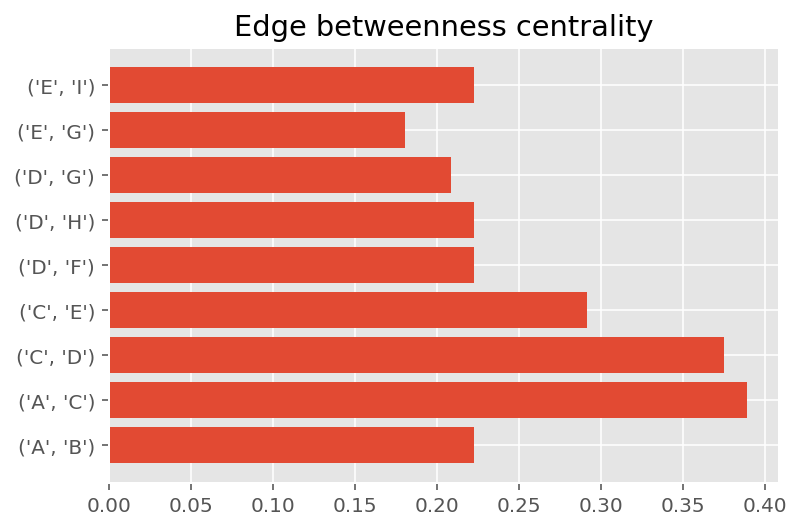

In [13]:
plt.barh(list(range(len(list(edge_centrality.values())))),
         list(edge_centrality.values()))
plt.yticks(list(range(len(edge_centrality))), list(edge_centrality.keys()))
plt.title('Edge betweenness centrality')
plt.show()

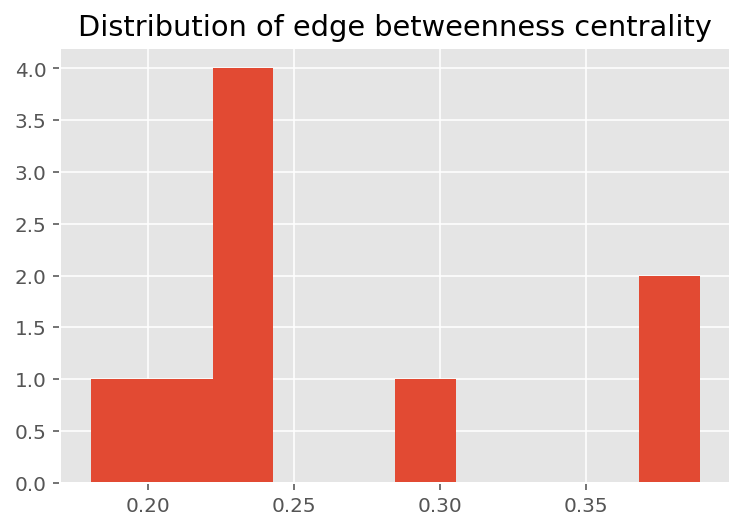

In [14]:
plt.hist(list(edge_centrality.values()))
plt.title('Distribution of edge betweenness centrality')
plt.show()

## Robustness

An interesting question in network theory is how robust a network is. That means what influence does the removal of nodes or links have on the network, if it will still work or be disrupted. We assume that a network does not work properly any more if the number of nodes in the giant component is significantly reduced (for example in one of the recent tube strikes). One can think of random failure (for example a computer in a cluster) or targeted attacks (for example by hackers).

We try first how long it takes until a network becomes disconnected by random node elimination. 
Then we will try a targeted attack.

### Breaking the giant component

In [15]:
import copy


def breaking_graph(H, node_list):
    # define the new graph as the subgraph induced by the GCC
    n_l = copy.deepcopy(node_list)
    # continue deleting nodes from the GCC while the graph consists of a
    # single component (num_components=1)
    num_components = 1
    count = 0
    while num_components == 1:
        count += 1
        #node_to_delete = random.choice(H.nodes())
        # select at random an element in the node list or
        # select a node according to the betweenness ranking
        # (the last in the list)
        node_to_delete = n_l.pop()
        H.remove_node(node_to_delete)
        #(GCC,num_components) = giant_component_size(H)
        num_components = nx.number_connected_components(H)
    return count

### Breaking the graph randomly

In [16]:
G_GCC = G_test.subgraph(GCC).copy()

In [17]:
G_GCC.nodes()

NodeView(('A', 'B', 'C', 'D', 'E', 'F', 'H', 'G', 'I'))

In [18]:
random_list = copy.deepcopy(list(G_GCC.nodes()))
np.random.shuffle(random_list)

c = breaking_graph(G_GCC, random_list)

print("num of iterations:", c)

num of iterations: 1


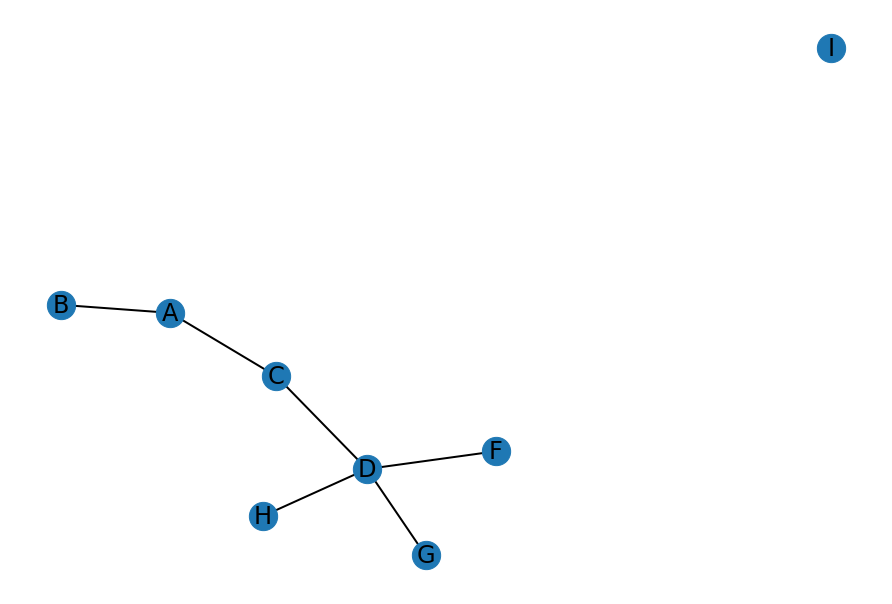

In [19]:
graphviz_pos = nx.drawing.layout.spring_layout(G_GCC)
nx.draw(G_GCC, graphviz_pos, node_size=200,
        with_labels=True)

### Averaging the random result

Now we use a dataset from the [cosinproject](http://www.cosinproject.eu/extra/data/internet/nlanr.html).
The chosen graph represents the Autonomous Systems topology of the Internet. Every vertex represents an autonomous system, and two vertices are connected if there is at least one physical link between the two corresponding Autonomous Systems. 

To simulate the random failure, we remove links until the giant component gets broken. We repeat that process several times to obtain an average number of link removals required.

In [20]:
data = pd.read_csv('assets/datasets/AS-19971108.dat', sep=' ', header=None)

In [21]:
data.head()

,0,1
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6


In [22]:
# loading the Autonomous System (AS) graph
G_AS = nx.Graph()
G_AS.add_edges_from(data.values)
print(nx.info(G_AS))

GCC, components, num_components = giant_component_size(G_AS)

Name: 
Type: Graph
Number of nodes: 3015
Number of edges: 5156
Average degree:   3.4202


In [23]:
n_iter = 1000
count = 0.0
for i in range(n_iter):
    G_GCC = G_AS.subgraph(GCC).copy()
    random_list = copy.deepcopy(list(G_GCC.nodes()))
    np.random.shuffle(random_list)
    c = breaking_graph(G_GCC, random_list)
    count += c

print("average iterations to break GCC:", count/n_iter)

average iterations to break GCC: 8.466


### Breaking with Betweenness Centrality

To target our attack, we have to identify nodes or links which have more importance for the connectedness of the network, for example according to betweenness centrality. 

Following that logic, we will determine the node with the highest betweenness and remove it. The connectedness breaks down very fast.

In [24]:
import operator

G_GCC = G_AS.subgraph(GCC).copy()

node_centrality = nx.betweenness_centrality(G_GCC)

sorted_bc = sorted(list(node_centrality.items()), 
                   key=operator.itemgetter(1))

# selecting the ranked node list
node_ranking = [item[0] for item in sorted_bc]

c = breaking_graph(G_GCC, node_ranking)

print("num of iterations:", c)

num of iterations: 1


In [25]:
n_iter = 1000
count = 0.0
for i in range(n_iter):
    G_GCC = G_AS.subgraph(GCC).copy()
    c = breaking_graph(G_GCC, node_ranking)
    count += c

print("average iterations to break GCC:", count/n_iter)

average iterations to break GCC: 1.0


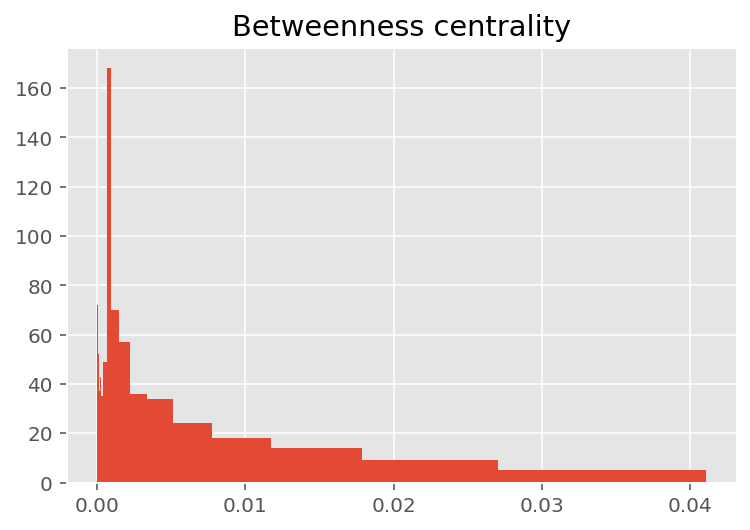

In [26]:
plt.hist(list(node_centrality.values()),
         bins=np.logspace(-3*np.log(5), -1*np.log(4), 20))
plt.title('Betweenness centrality')
plt.show()

## Community detection

One of the central problems in network theory is community detection, identifying groups of nodes which are more closely related to each other than to other nodes in the network. There are different methods for detecting such communities. 
For an expert overview see Santo Fortunato's [review](https://arxiv.org/abs/0906.0612) or his [blog](http://digitalinterface.blogspot.co.uk/2013/05/community-detection-in-graphs.html) for a more gentle introduction.

## The Girvan-Newman algorithm 


One of these methods is given by the Girvan-Newman algorithm and is based on the edge betweenness. One starts with a connected network and removes the edge with the highest betweenness obtaining a new network with one edge less. One calculates again the betweenness for all edges (by the edge removal it has changed), removes the one with the highest betweenness and so on. The network will split into more and more disconnected components until either the desired number of disconnected components, i.e. communities, is reached or all edges have been removed.

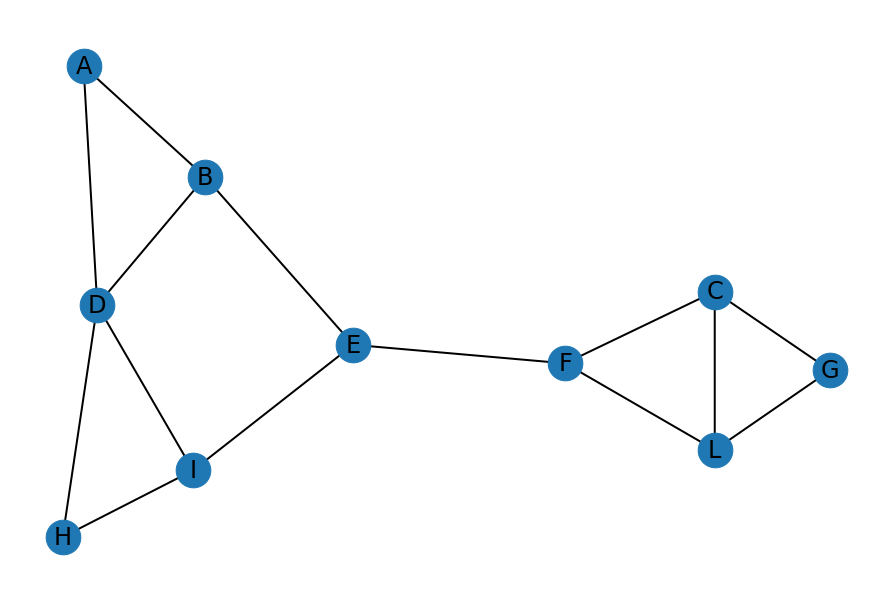

In [27]:
G = nx.Graph()
G.add_edges_from([('A', 'B'), ('A', 'D'), ('B', 'D'), ('B', 'E'), ('E', 'I'),
                  ('D', 'I'), ('D', 'H'), ('H', 'I'), ('E', 'F'), ('F', 'C'),
                  ('F', 'L'), ('C', 'L'), ('C', 'G'), ('G', 'L')])

pos = nx.drawing.spring_layout(G)

nx.draw(G, pos, with_labels=True)
plt.show()

In [28]:
def Girvan_Newman(G_1):
    G = G_1.copy()
    pos = nx.drawing.spring_layout(G)
    sorted_bc = [1]
    actual_number_components = 1
    while not sorted_bc == []:
        d_edge = nx.edge_betweenness_centrality(G)
        sorted_bc = sorted(list(d_edge.items()), key=operator.itemgetter(1))
        e = sorted_bc.pop()
        print("deleting edge:", e[0], end=' ')
        G.remove_edge(*e[0])
        num_comp = nx.number_connected_components(G)
        print("...we have now ", num_comp, " components")
        if num_comp > actual_number_components:
            actual_number_components = num_comp
            if num_comp < 7:
                nx.draw(G, pos, with_labels=True)
                plt.show()

deleting edge: ('E', 'F') ...we have now  2  components


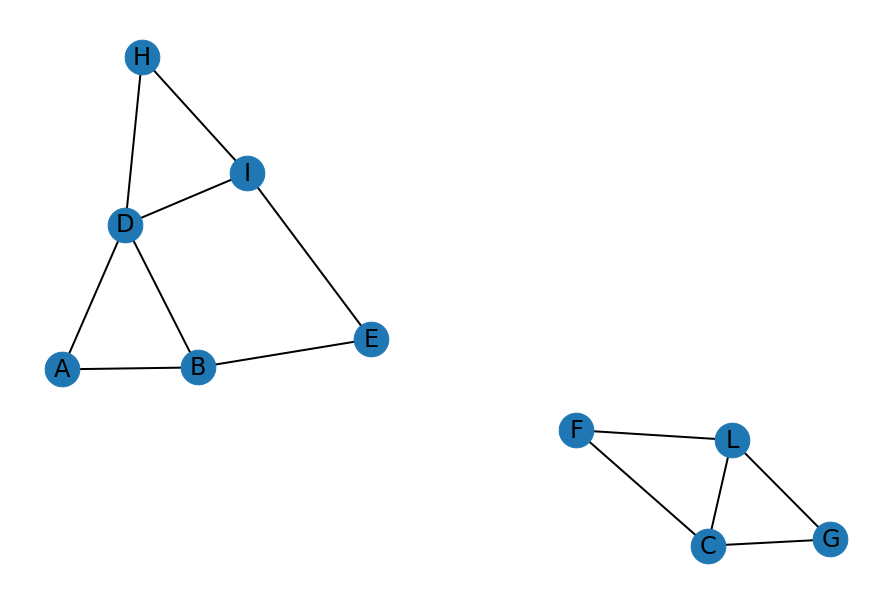

deleting edge: ('E', 'I') ...we have now  2  components
deleting edge: ('B', 'D') ...we have now  2  components
deleting edge: ('A', 'D') ...we have now  3  components


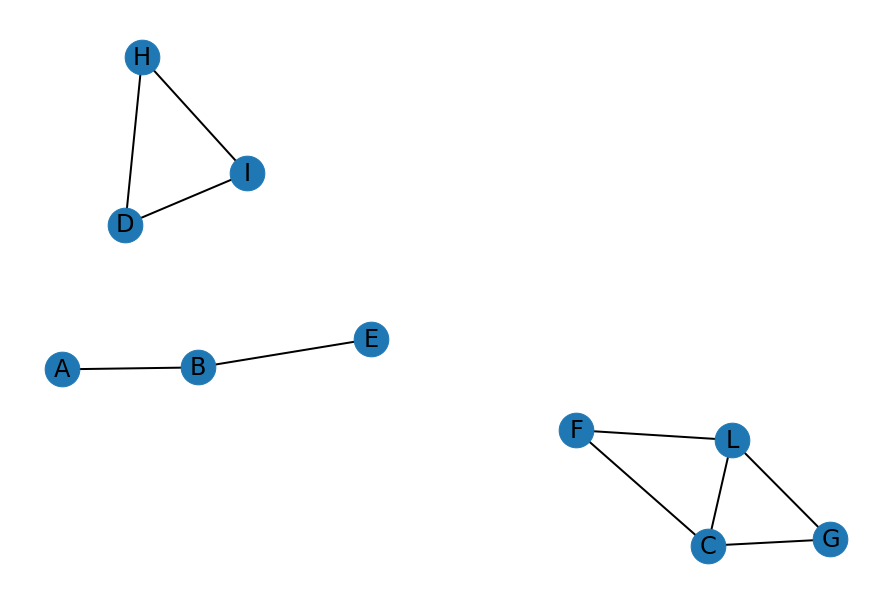

deleting edge: ('B', 'E') ...we have now  4  components


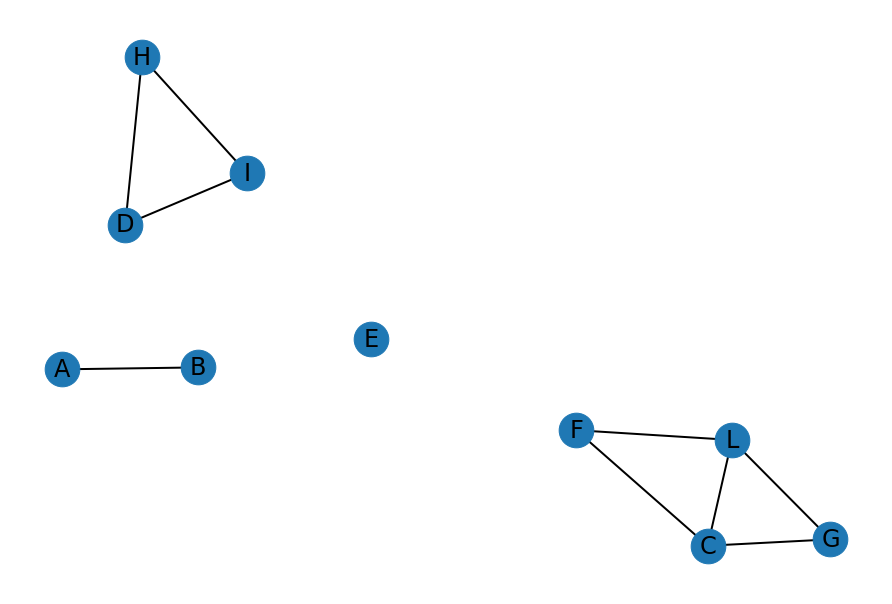

deleting edge: ('L', 'G') ...we have now  4  components
deleting edge: ('C', 'G') ...we have now  5  components


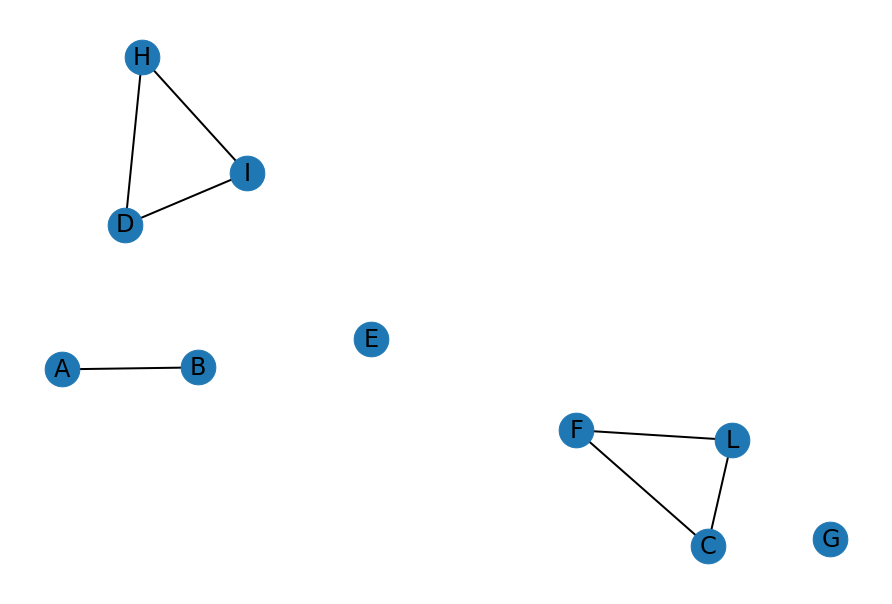

deleting edge: ('C', 'L') ...we have now  5  components
deleting edge: ('F', 'L') ...we have now  6  components


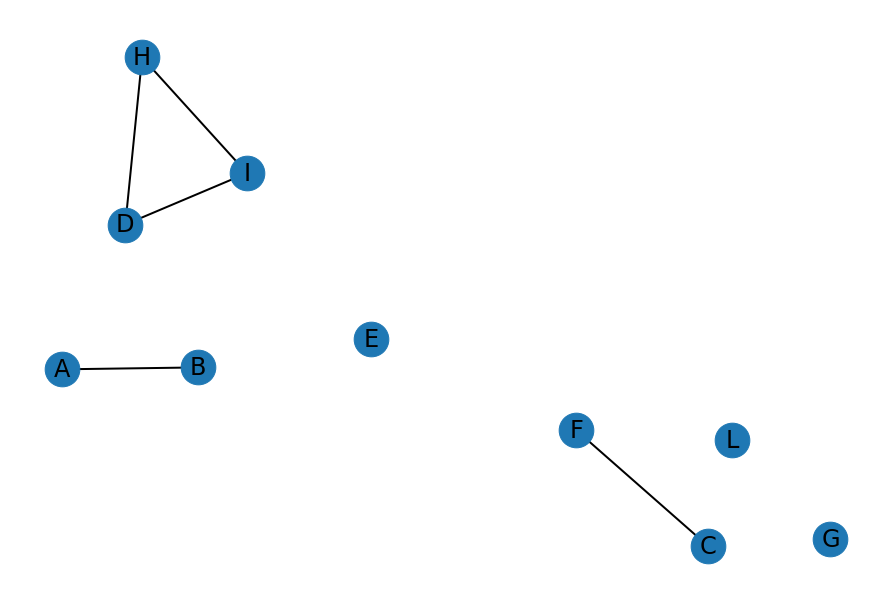

deleting edge: ('F', 'C') ...we have now  7  components
deleting edge: ('I', 'H') ...we have now  7  components
deleting edge: ('D', 'H') ...we have now  8  components
deleting edge: ('D', 'I') ...we have now  9  components
deleting edge: ('A', 'B') ...we have now  10  components


In [29]:
Girvan_Newman(G)

The same result can be obtained in the following way:

In [30]:
list(nx.community.girvan_newman(G))

[({'A', 'B', 'D', 'E', 'H', 'I'}, {'C', 'F', 'G', 'L'}),
 ({'A', 'B', 'E'}, {'D', 'H', 'I'}, {'C', 'F', 'G', 'L'}),
 ({'A'}, {'B', 'E'}, {'D', 'H', 'I'}, {'C', 'F', 'G', 'L'}),
 ({'A'}, {'B', 'E'}, {'D', 'H', 'I'}, {'F'}, {'C', 'G', 'L'}),
 ({'A'}, {'B'}, {'D', 'H', 'I'}, {'E'}, {'F'}, {'C', 'G', 'L'}),
 ({'A'}, {'B'}, {'D'}, {'E'}, {'H', 'I'}, {'F'}, {'C', 'G', 'L'}),
 ({'A'}, {'B'}, {'D'}, {'E'}, {'I'}, {'H'}, {'F'}, {'C', 'G', 'L'}),
 ({'A'}, {'B'}, {'D'}, {'E'}, {'I'}, {'H'}, {'F'}, {'C'}, {'G', 'L'}),
 ({'A'}, {'B'}, {'D'}, {'E'}, {'I'}, {'H'}, {'F'}, {'C'}, {'L'}, {'G'})]

## Hierarchical clustering

The method of (agglomerative) hierarchical clustering we already met before. For networks it is based on the adjacency matrix from which we can calculate the distance matrix by defining some similarity measure between the nodes. For example one can use **cosine similarity** which one can calculate for each pair of row vector $x$ and column vector $y$ of the adjacency matrix obtaining 

$$\sigma_{ij} = \frac{x\cdot y}{\|x\|\|y\|}$$

($\|\cdot\|$ indicates taking the norm of the corresponding vector, here the Euclidean length)
with the intuitive interpretation that the cosine similarity is high if two nodes share a large number of common neighbours. The name results from the fact that the calculated number gives the cosine of the angle between the two vectors $x$ and $y$.

In the end we obtain a dendrogram. Cutting it at different heights we obtain different numbers of communities.

**Note:** One would expect that all members of a community can be reached through other members of the community.

In [31]:
from scipy.cluster import hierarchy
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, cosine, jaccard

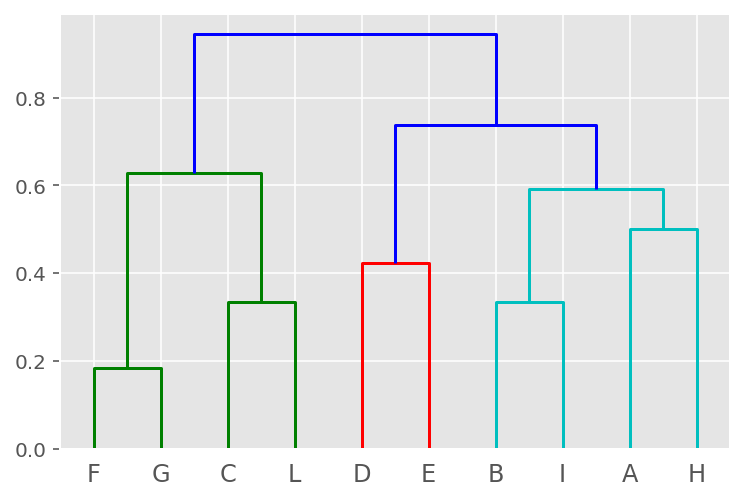

In [32]:
A = nx.adjacency_matrix(G).toarray()
dist_out = pdist(A, metric='cosine')
Z = hierarchy.linkage(dist_out, method='average')
hierarchy.dendrogram(Z, leaf_rotation=0, labels=list(G.nodes()))
plt.show()

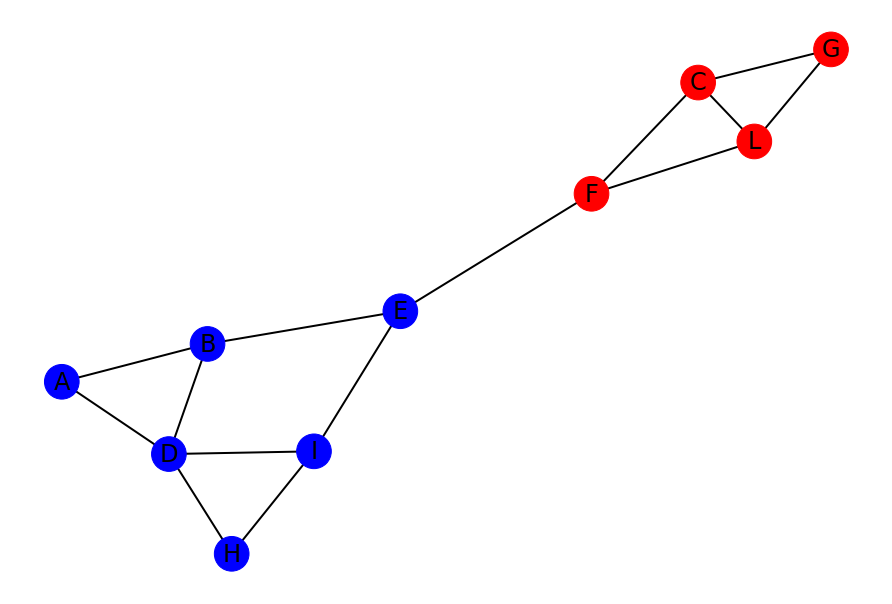

In [33]:
np.random.seed(100)
clusters = hierarchy.fcluster(Z, 2, criterion='maxclust')
dict_cluster = dict(list(zip(G.nodes(), clusters)))

colors = ['red', 'blue', 'green', 'yellow', 'orange', 'black']
node_colors = []
for key in dict_cluster:
    for i in list(set(dict_cluster.values())):
        if dict_cluster[key] == i:
            node_colors.append(colors[i-1])

nx.draw_spring(G, node_color=node_colors, with_labels=True)

### Exercise

Apply Girvan-Newman and hierarchical clustering to the 

- Karate Club Graph
- Women-Davis Graph
- Les-Miserables Graph

Try out different settings and report your findings.

In [36]:
G_karate = nx.karate_club_graph()
G_davis = nx.davis_southern_women_graph()
G_mis = nx.les_miserables_graph()

#### Solution Karate Club Graph (double click)

<span style="color:white;font-family:'Courier New'"><br/>
print("Girvan Newman Algorithm")
Girvan_Newman(G_karate)
def hierarchical_clustering(G_1, maxclust=2,
                            fcluster_kwargs={'criterion': 'maxclust'}, 
                            linkage_kwargs={'method': 'average'},
                            metric_kwargs={'metric': 'cosine'},
                            dendrogram_kwargs={'leaf_rotation': 90}):
    G = G_1.copy()
    A = nx.adjacency_matrix(G).toarray()
    dist_out = pdist(A, **metric_kwargs)
    Z = hierarchy.linkage(dist_out, **linkage_kwargs)
    hierarchy.dendrogram(Z, **dendrogram_kwargs)
    plt.show()
    np.random.seed(100)
    clusters = hierarchy.fcluster(Z, maxclust, **fcluster_kwargs)
    dict_cluster = dict(list(zip(G.nodes(), clusters)))
    nx.draw_spring(G, node_color=clusters, cmap='rainbow', with_labels=True)
print("Hierarchical Clustering")
hierarchical_clustering(G_karate, maxclust=4)
</span>

#### Solution Davis Graph (double click)

<span style="color:white;font-family:'Courier New'"><br/>
print("Girvan Newman Algorithm")
Girvan_Newman(G_davis)
print("Hierarchical Clustering")
hierarchical_clustering(G_davis, dendrogram_kwargs={'leaf_rotation': 90, 'labels': list(G_davis.nodes())})
</span>

#### Solution Les Miserables Graph (double click)

<span style="color:white;font-family:'Courier New'"><br/>
print("Girvan Newman Algorithm")
Girvan_Newman(G_mis)
print("Hierarchical Clustering")
hierarchical_clustering(G_mis, maxclust=12,
                        linkage_kwargs={'method': 'complete'},
                        dendrogram_kwargs={'leaf_rotation': 90, 'labels': list(G_mis.nodes())})
</span>

## Conclusions

- What are centrality measures useful for?
- What does robustness mean? What is the difference between random failure and targeted attacks?
- Describe the Girvan-Newman algorithm and hierarchical clustering.

## Additional Resources

There are some very good references.
These two books present both the formalism as well as many applications and have very readable introductory parts:
* Albert-László Barabási: Network Science, Cambridge University Press, 2016 [online version](http://barabasi.com/networksciencebook/)
* Mark Newman: Networks, Oxford University Press, 2010

This book illustrates the use of networkx with applications to a range of datasets in worked out examples. Several examples in this lesson are from this book.

* Guido Caldarelli, Alessandro Chessa: Data Science and Complex Networks, Oxford University Press, 2016 (http://book.complexnetworks.net/)

A popular scientific book which is really recommandable for getting familiar with this topic is 
* Albert-László Barabási: Linked, Perseus Publishing, 2002 

Resources on community detection:
* Santo Fortunato's [review](https://arxiv.org/abs/0906.0612) or his [blog](http://digitalinterface.blogspot.co.uk/2013/05/community-detection-in-graphs.html) 

## Network data resources
There are several sources of network datasets:
1. [Stanford Large Network Dataset Collection](https://snap.stanford.edu/data/index.html)
1. [Manlio De Domenico's collection](https://comunelab.fbk.eu/data.php)
1. [UC Irvine Network Data Repository](http://networkdata.ics.uci.edu/)
1. [University of Koblenz repository](http://konect.uni-koblenz.de/networks/)